In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import cycle
from datetime import datetime
import json

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torchinfo import summary

from utils import (load_all_data, 
                   squeeze_and_concat, 
                   filter_mask_keep_labels, 
                   multiclass_dice_loss, 
                   check_gradients)
from datasets import MultiTissueDataset
from unet_advanced import UNetAdvanced as UNetGan
from gan_basic import DiscriminatorModel
from train_utils import EarlyStopping, save_checkpoint

%load_ext autoreload
%autoreload 2


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")
print(f'Num available GPUs: ', torch.cuda.device_count())


p = torch.cuda.get_device_properties()
print(f"Device: {p.name} (Memory: {p.total_memory / 1e9:.2f} GB)")

Selected device: cuda
Num available GPUs:  1
Device: NVIDIA TITAN RTX (Memory: 25.19 GB)


In [3]:
# Data import 
DATA_FOLDER = "/scratch/pdiciano/GenAI/ACDC_mine/data/ACDC_tissue_prop"

data = load_all_data(DATA_FOLDER)
data_concat = squeeze_and_concat(data)

mask_keep_labels = [0, 1, 2, 3]  # ventricule right, ventricule left, myocardium right, myocardium left
data_concat['input_labels'] = filter_mask_keep_labels(data_concat['multiClassMasks'], mask_keep_labels)

## Model 1
Generator: CE loss 10 times more weighted than GAN loss

In [4]:
dir_name = "experiments/20260210_0928_MT_basic_gan"

In [5]:
if os.path.exists(dir_name):
    if os.path.isfile(dir_name + "/config.json") or os.path.isfile(dir_name + "/metrics_history.json"):
        with open(f"{dir_name}/config.json", "r") as f:
            training_config = json.load(f)

        with open(f"{dir_name}/metrics_history.json", "r") as f:
            metrics_history = json.load(f)
    
    if os.path.isfile(dir_name + "/train_val_split.json"):
        with open(f"{dir_name}/train_val_split.json", "r") as f:
            train_val_split = json.load(f)


In [6]:
training_config

{'num_steps': 7500,
 'n_discr_steps': 1,
 'lambda_ce': 10.0,
 'val_check_interval': 120,
 'batch_size': 16,
 'learning_rate_gen': 0.0001,
 'learning_rate_discr': 0.0001,
 'notes': 'N/A',
 'patience_es': 5,
 'dropout_gen': 0.3,
 'num_gpus': 2,
 'validation_fraction': 0.2}

In [7]:
val_indices = train_val_split['val_indices']
val_dataset = MultiTissueDataset({k: v[val_indices] for k, v in data_concat.items()})
dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)


batch = next(iter(dataloader))

In [8]:
# gen = nn.DataParallel(UNetGan(in_ch=4, num_classes=12, dropout_p=0.3)).to(device)
gen = nn.DataParallel(UNetGan(in_ch=4, num_classes=12, dropout_p=0.3).to(device))
gen.load_state_dict(torch.load(dir_name+"/best_generator.pth", weights_only=True))
gen.eval()


DataParallel(
  (module): UNetAdvanced(
    (inc): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (inblock): BasicBlock(
      (conv1): ConvNormAct(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): GELU(approximate='none')
      )
      (conv2): ConvNormAct(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): GELU(approximate='none')
      )
      (shortcut): Sequential()
    )
    (down1): down_block(
      (conv): Sequential(
        (0): BasicBlock(
          (conv1): ConvNormAct(
            (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [9]:
with torch.no_grad():
    gen.eval()
    input_label = batch['input_label'].to(device)
    multi_tissue_masks = batch['multiClassMask'].to(device)
    output = gen(input_label)

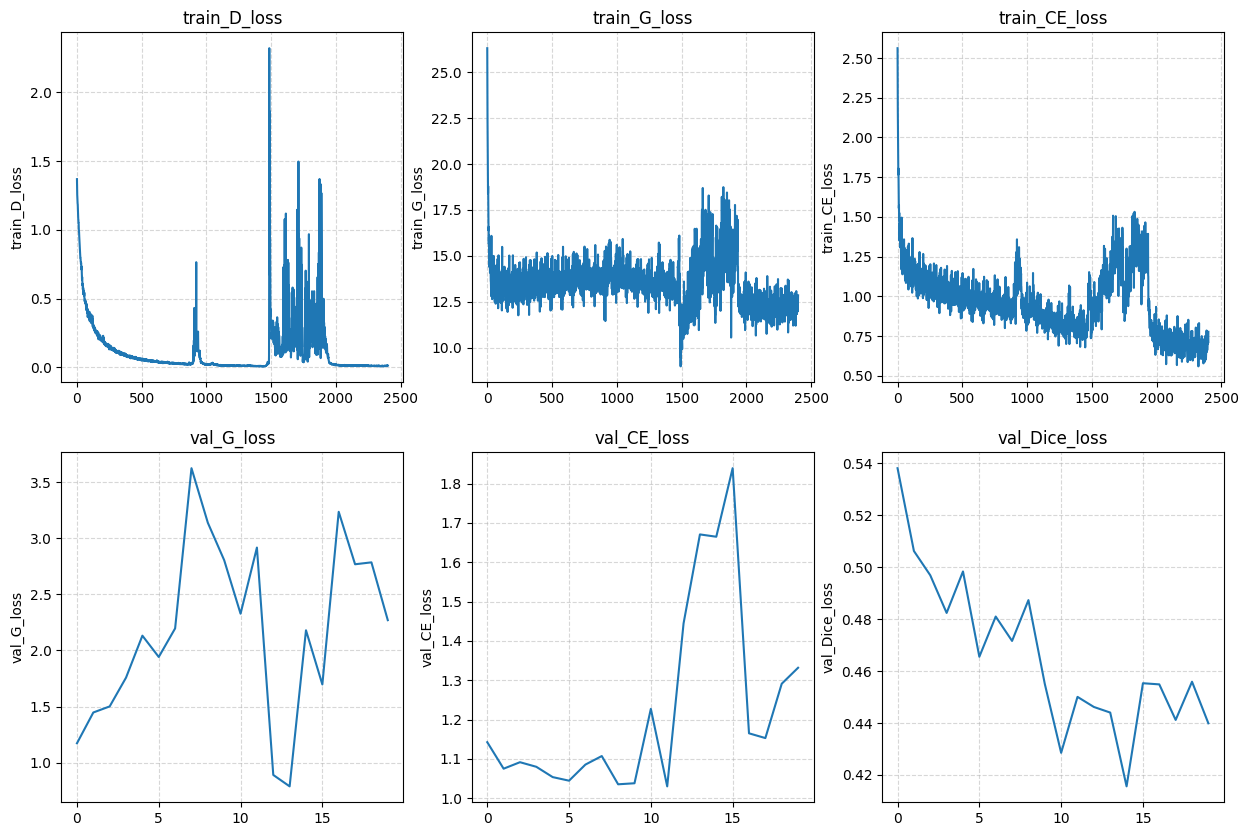

In [10]:
fig, ax = plt.subplots(2, len(metrics_history)//2, figsize=(15, 10))

ax = ax.flatten()
for i, (metric_name, metric_values) in enumerate(metrics_history.items()):
    if metric_name == 'current_step':
        break
    ax[i].plot(metric_values)
    ax[i].set_title(metric_name)
    ax[i].set_ylabel(metric_name)
    ax[i].grid(linestyle='--', alpha=0.5)

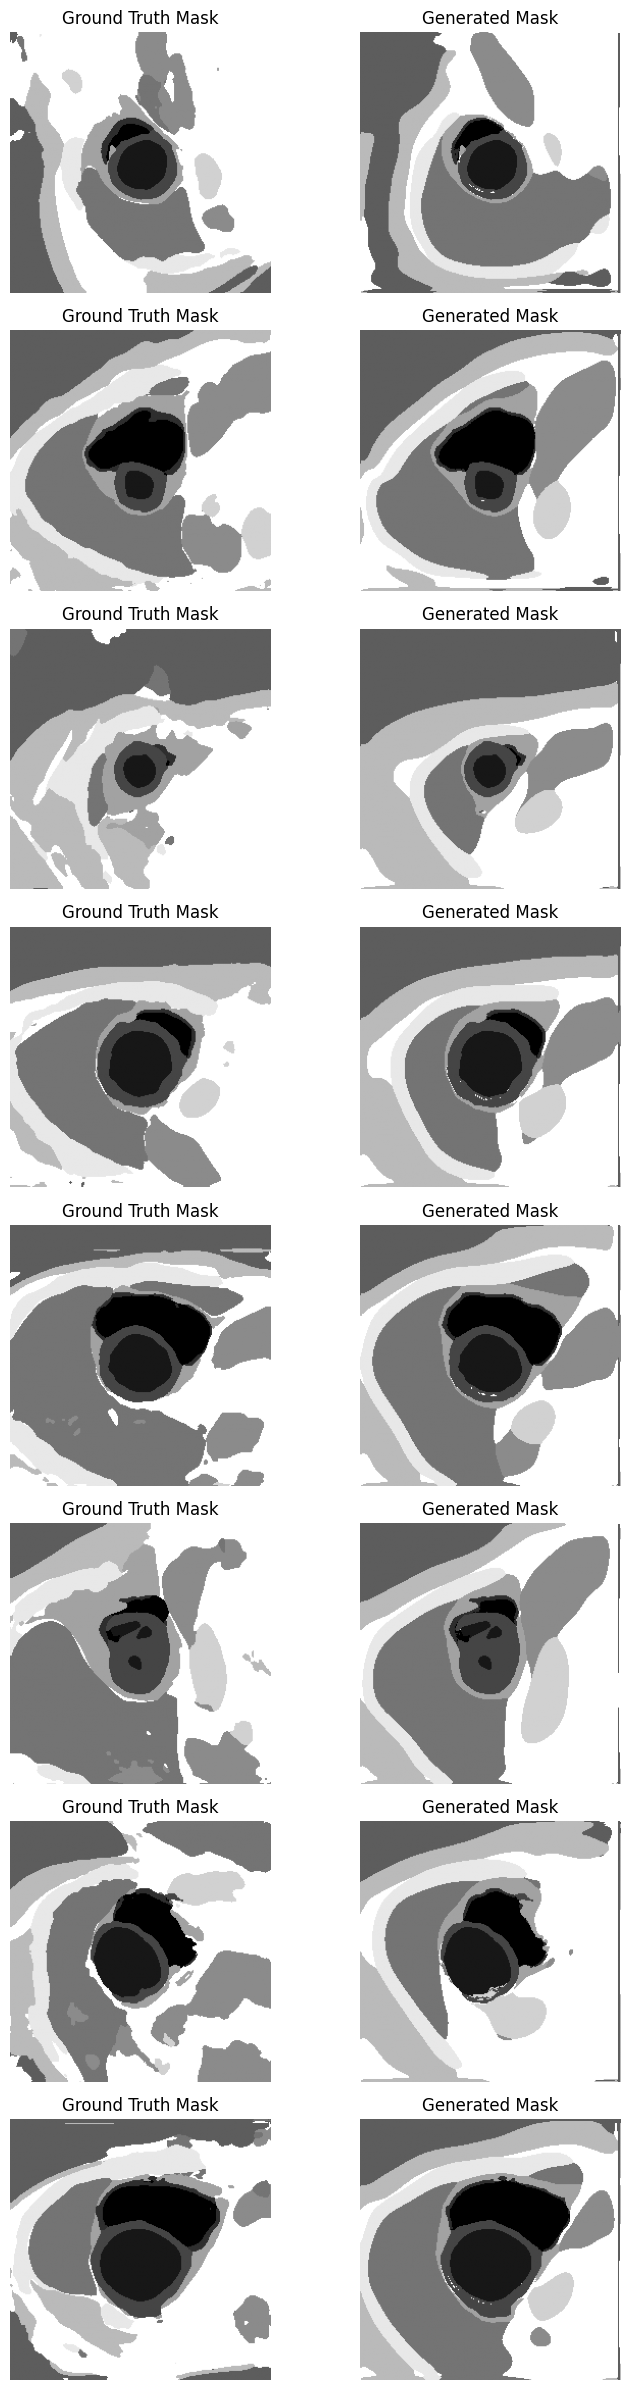

In [11]:
fig, ax = plt.subplots(len(batch['input_label']), 2, figsize=(8, 24))

for i in range(len(batch['input_label'])):
    ax[i, 0].imshow(multi_tissue_masks[i].cpu().numpy(), cmap='gray')
    ax[i, 0].set_title('Ground Truth Mask')
    ax[i, 0].axis('off')

    output_mask = torch.argmax(output[i], dim=0).cpu().numpy()
    ax[i, 1].imshow(output_mask, cmap='gray')
    ax[i, 1].set_title('Generated Mask')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

## Model 2
LR Discriminator 10 times lower than LR generator. CE loss 10 times higher than GAN loss

In [12]:
dir_name = "experiments/20260210_0940_MT_basic_gan"

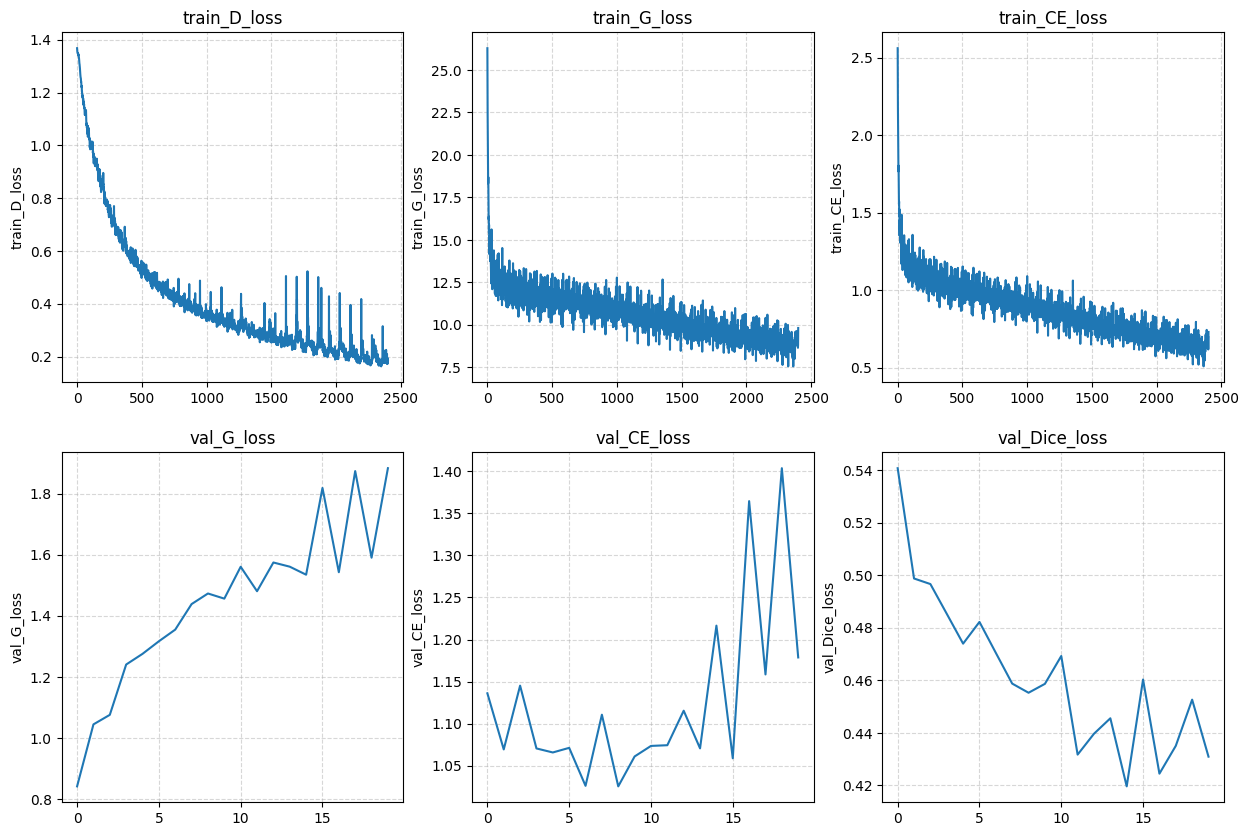

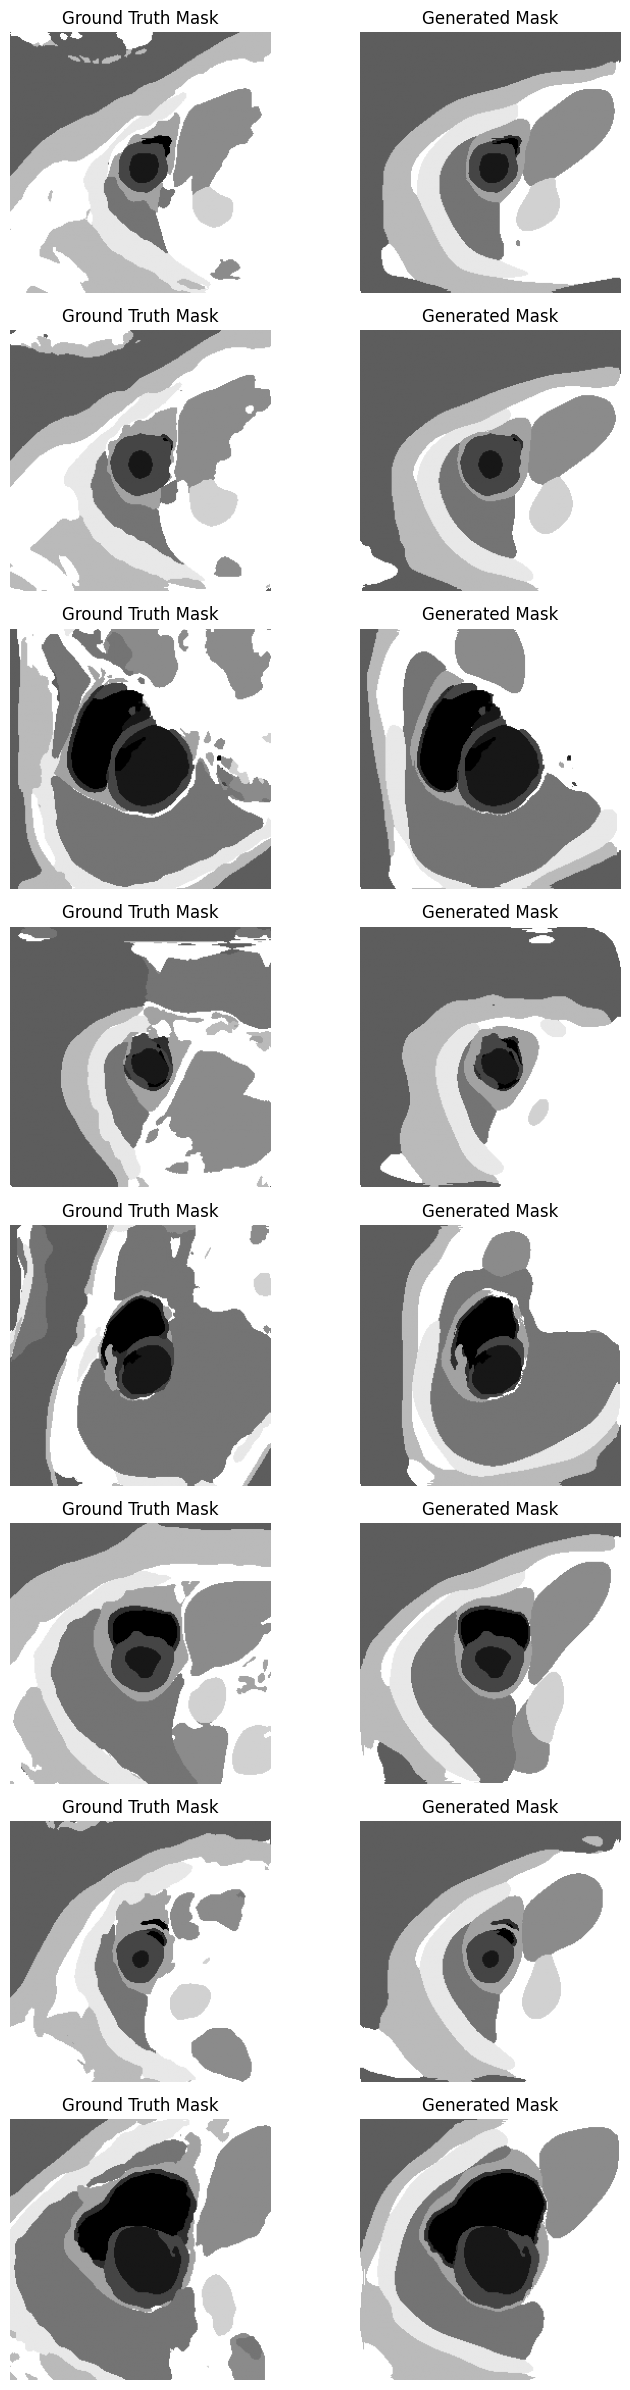

{'num_steps': 7500,
 'n_discr_steps': 1,
 'lambda_ce': 10.0,
 'val_check_interval': 120,
 'batch_size': 16,
 'learning_rate_gen': 0.0001,
 'learning_rate_discr': 1e-05,
 'notes': 'Discr learning rate 10 times lower than the generator one.',
 'patience_es': 5,
 'delta_es': 0.01,
 'dropout_gen': 0.3,
 'num_gpus': 2,
 'validation_fraction': 0.2,
 'seed': 187}

In [13]:
if os.path.exists(dir_name):
    if os.path.isfile(dir_name + "/config.json") or os.path.isfile(dir_name + "/metrics_history.json"):
        with open(f"{dir_name}/config.json", "r") as f:
            training_config = json.load(f)

        with open(f"{dir_name}/metrics_history.json", "r") as f:
            metrics_history = json.load(f)
    
    if os.path.isfile(dir_name + "/train_val_split.json"):
        with open(f"{dir_name}/train_val_split.json", "r") as f:
            train_val_split = json.load(f)


# plot metrics
fig, ax = plt.subplots(2, len(metrics_history)//2, figsize=(15, 10))

ax = ax.flatten()
for i, (metric_name, metric_values) in enumerate(metrics_history.items()):
    if metric_name == 'current_step':
        break
    ax[i].plot(metric_values)
    ax[i].set_title(metric_name)
    ax[i].set_ylabel(metric_name)
    ax[i].grid(linestyle='--', alpha=0.5)


# Val indices
val_indices = train_val_split['val_indices']
val_dataset = MultiTissueDataset({k: v[val_indices] for k, v in data_concat.items()})
dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

batch = next(iter(dataloader))


# Predictions
gen = nn.DataParallel(UNetGan(in_ch=4, num_classes=12, dropout_p=0.3).to(device))
gen.load_state_dict(torch.load(dir_name+"/best_generator.pth", weights_only=True))
gen.eval()

with torch.no_grad():
    input_label = batch['input_label'].to(device)
    multi_tissue_masks = batch['multiClassMask'].to(device)
    output = gen(input_label)



# Plot images
fig, ax = plt.subplots(len(batch['input_label']), 2, figsize=(8, 24))

for i in range(len(batch['input_label'])):
    ax[i, 0].imshow(multi_tissue_masks[i].cpu().numpy(), cmap='gray')
    ax[i, 0].set_title('Ground Truth Mask')
    ax[i, 0].axis('off')

    output_mask = torch.argmax(output[i], dim=0).cpu().numpy()
    ax[i, 1].imshow(output_mask, cmap='gray')
    ax[i, 1].set_title('Generated Mask')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

training_config